This is the third in a series of notebooks designed for the "Hackathon" at the TESS Interactive Data Workshop at the winter AAS meeting.

The hackathon notebooks are intended to be a non-comprehensive guide on to how to approach different problems with TESS. It is up to the user to fill in the blanks to customize the notebook to their interests. Because of this, a basic knowledge of TESS data handling is prerequisite to these notebooks.

If you are new to TESS, please first refer to the following tutorials before proceeding further. MAST tutorials (also available on TIKE): https://github.com/spacetelescope/tike_content/blob/main/content/science-examples-github.md lightkurve tutorials: https://docs.lightkurve.org/tutorials/index.html


# Learning Goals
In this tutorial we will learnhow to:
- Access and download TESS data of NGC 4151
- Construct Aperture masks for our target souce and background region
- Compute a background subtracted lightcurve
- Remove epochs of questionable data
- Construct a Lomb-Scargle Periodogram
- Save and load our data

# Introduction

NGC 4151 is a face-on nearby Seyfert galaxy with a bright, variable AGN at the center.  It's combined orienation and nearby location mean that this galaxy can serve as an excellent test-bed for AGN studies as the [JWST DD-ERS program from Bentz et al.](https://www.stsci.edu/jwst/science-execution/approved-programs/dd-ers/program-1364) demonstrates.  In this notebook we will search for, download, and examine the TESS observations of this object, and others assosciated with this proposal.  

In [1]:
%matplotlib inline
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from lightkurve import MPLSTYLE
from astropy.io import fits

# Downloading the Data

While NGC 4151 was not previously observed by TESS in its rapid exposure mode, it is still available as part of the binned CCD Full-Frame images.  To find what data exists, lets use lightkurve to search the [TESSCut](https://mast.stsci.edu/tesscut/) MAST webportal, which cuts out time-series postage stamps from TESS CCD FFI's and delivers them to the user.

In [2]:
target = lk.search_tesscut('NGC 4151')
target

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 49,2022,TESScut,475,NGC 4151,0.0


We see here that there is 1 sector of data available, from Sector 49.  Checking the [TESS Observing Dates](https://heasarc.gsfc.nasa.gov/docs/tess/sector.html) calendar, we can see that this data was taken between Feb 26-Mar 26, 2022.  We can check to see if NGC 4151 is scheduled to be observed in any currently planned sectors by going to the [TESS Web Viewing Tool](https://heasarc.gsfc.nasa.gov/wsgi-scripts/TESS/TESS-point_Web_Tool/TESS-point_Web_Tool/wtv_v2.0.py/) and putting in the appropriate information.  This target will be observed again in Sector 76 beginning in late February 2024. 

Prior to downloading a time-series postage stamp of data around the AGN, we want to set some quality flags for data to exclude.  As a starting point, we reccomend:

In [3]:
bitmask = (lk.utils.TessQualityFlags.SafeMode |
           lk.utils.TessQualityFlags.CoarsePoint |
           lk.utils.TessQualityFlags.ManualExclude  |
           lk.utils.TessQualityFlags.Argabrightening | 
           lk.utils.TessQualityFlags.CollateralCosmic)


This excludes a number of known bad data points from sources such as Safe Modes, poor pointing, and "manual" excludes where the TESS pipeline team has flagged a bad cadence. You can [read more about them in the TESS Science Data Products Description](https://archive.stsci.edu/missions/tess/doc/EXP-TESS-ARC-ICD-TM-0014.pdf)(Sec. 9/Pg. 49).  

Using this, we want to download a target pixel file (TPF) which is a time-series postage  stamp that is a square area around our source at each epoch of TESS observations.  NGC is a large, extended galaxy - we recommend starting at a 15 x 15 pixel stamp size, and can be retrieved like so:

In [4]:
tpf=target.download(cutout_size=15,quality_bitmask=bitmask)

## Lets see what we have! 
We can plot the 2-D area of the TPF for a single epoch using the plot tool:

<Axes: title={'center': 'Target ID: NGC 4151, Cadence: 0'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

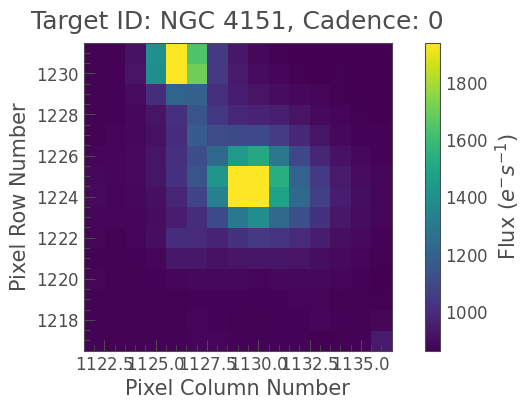

In [5]:
tpf.plot()

Or, we can look at the raw lightcuve on a per-pixel basis using the lightkurve interact tool: 

In [6]:
# Interact will not render outside of a jupyter notebook
tpf.interact()


We see what NGC4151 looks like in the optical thanks Hubble Space Telescope observations of NGC 4151 with WFC3 [here.](https://webbtelescope.org/contents/media/images/2018/37/4227-Image?news=true) 


Most of its luminosity comes from the central AGN.  Using the interact tool, we can see that most of the AGN flux is in the center top-right pixel (Column=1130, Row=1225),   but significan amounts are also in 3 nearby pixels (Column=1129-1130, Row = 1224-1225).     

Lets create a new aperature for photometry using only the highest valued pixels.   Given the variance across pixels, we can do this quickly by creating a mask based on a pixels value compared to the standard deviation of the data.  Lets create a new aperature using only those pixels with a >30 $\sigma$ value:

<Axes: title={'center': 'Target Aperture'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

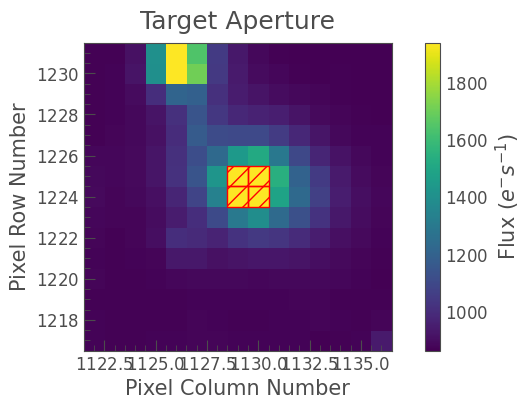

In [7]:
target_mask = tpf.create_threshold_mask(threshold=30)
tpf.plot(aperture_mask=target_mask,title="Target Aperture")

You could also make a boolean pixel aperture mask by hand if you wanted to include or exclude additional pixels.  Using this aperature, lets do some simple apereture photometry.  First, lets look at our 'raw' lightcurve from out aperture:

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

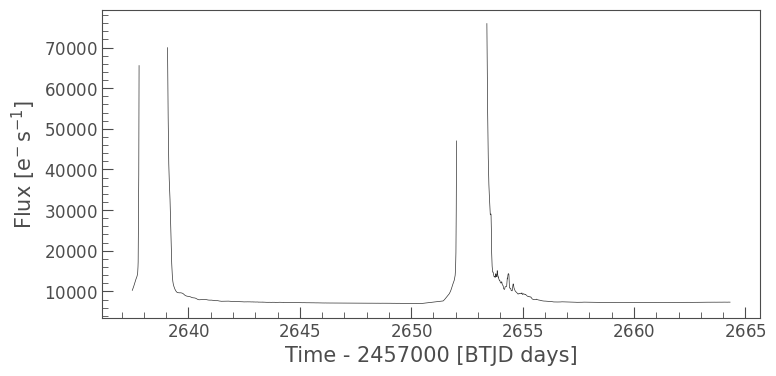

In [8]:
lc_raw=tpf.to_lightcurve(aperture_mask=target_mask)
lc_raw.plot()

There's clearly still background noise, bad data and instrumental effects in here - lets try and do better!  

First things first, lets do our best to subtract out the time-dependant background from our TPF. An easy first pass at this can be to grab an array of pixels that are separated from our target aperture by >1 pixel, and then remove the median of those pixels over time

<Axes: title={'center': 'Background Aperture'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

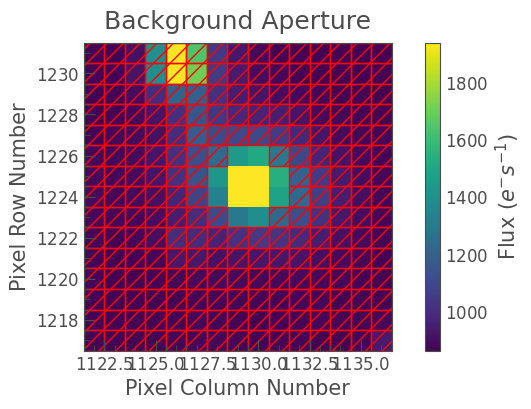

In [9]:
# This function makes a boolean mask larger by one pixel. 
# Our backgroud aperture will then be the inverse of this bigger aperture.
enlarge_aper = lambda x: np.any(np.asarray(np.gradient(x.astype(float))) != 0, axis=0) | x
bigger_mask = enlarge_aper(target_mask)
tpf.plot(aperture_mask=~bigger_mask,title="Background Aperture")

Then, using this new aperture, lets remove the median value of these pixels not in our expanded aperture in each epoch from each epoch, then plot our new background subtracted lightcurve!

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

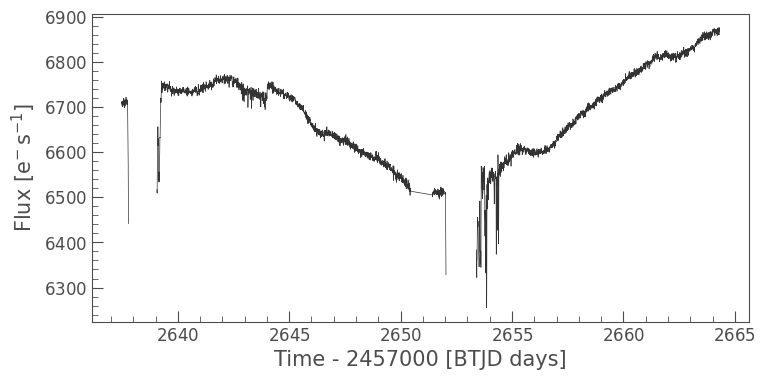

In [10]:
# Remove the median over time
tpf -= np.nanmedian(tpf.flux[:, ~bigger_mask], axis=1)[:, None, None]

# Make a new lightcurve from our background subtracted tpf
lc=tpf.to_lightcurve(aperture_mask=target_mask)
lc.plot(title='NGC4151')

This looks a lot better!  However, it looks like there is still some data suffering from instrumental effects - e.g. those points around the two orbit breakes (BTJDs ~ 2638.5 & 2654)  with sharp flux drops.  

One thing that can be causing those is the spacecraft pointing,  where the centroid of the object on the pixel wanders.  Lets check to see if this is stable - to do this, we will have the TPF estimate the centroids of our target given the attatched housekeeping data and evaluate these over time.   

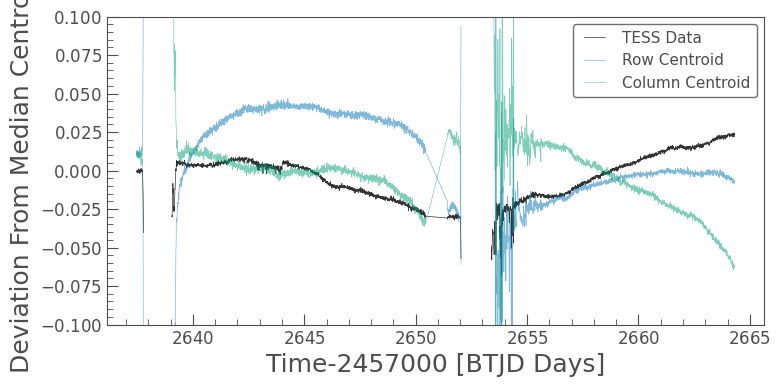

In [11]:
# Estimate the pointing centroids from the TPF
c_row,c_col = tpf.estimate_centroids()
with plt.style.context(MPLSTYLE):  
    ax = plt.figure().gca()
    plt.plot(lc.time.value,lc.flux.value/np.nanmedian(lc.flux.value) - 1,label='TESS Data')
    plt.plot(lc.time.value,c_row-np.nanmedian(c_row),alpha=0.5,label='Row Centroid')
    plt.plot(lc.time.value,c_col-np.nanmedian(c_col),alpha=0.5,label='Column Centroid')

    ax.set_ylim(-0.1,0.1)
    ax.set_xlabel('Time-2457000 [BTJD Days]',size=18)
    ax.set_ylabel('Deviation From Median Centroid',size=18)
    ax.legend()

From this comparison of the target centroiding vs. time we can see that many of the jumps in our background subtracted lightkurve are correlated with our large centroid variability.  Lets now flag and remove any points that have a large centroid deviation.  We'll do this in a reasonably principled manner by flagging some times as bad using visual inspection of the deviation data, but one could also in principle use sigma clipping or other outlier rejection methods to be more precise.  

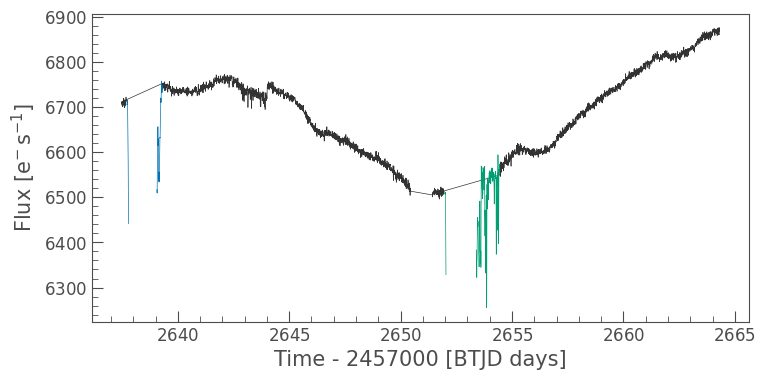

In [12]:
# Specify epochs with questionable pointing from the centroid information above
cut1 = ((lc.time.value > 2637.7) & (lc.time.value < 2639.3))
cut2 = ((lc.time.value > 2651.95) & (lc.time.value < 2654.45))
cut = cut1 | cut2

# Plot the flagged/unflagged data
with plt.style.context(MPLSTYLE):  
    ax = plt.figure().gca()
    lc[~cut].plot(ax=ax)
    plt.plot(lc.time.value[cut1],lc.flux.value[cut1])
    plt.plot(lc.time.value[cut2],lc.flux.value[cut2])


In [13]:
# Lets now remove the flagged epochs from our lightcurve object
lc = lc[~cut]
tpf=tpf[~cut]

We now have a background subtracted lightcurve, with epochs of questionable data quality removed, that looks like this:

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

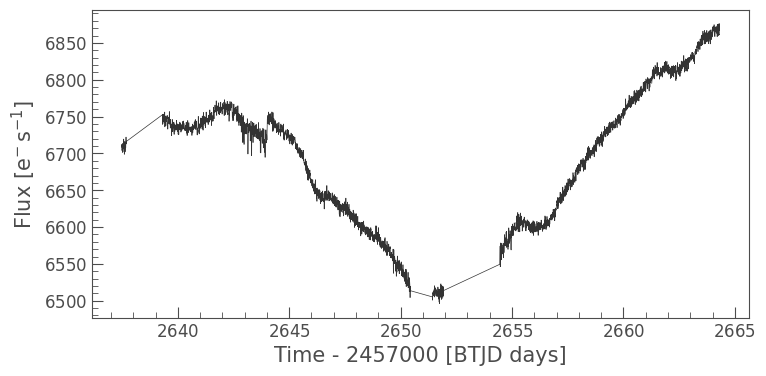

In [14]:
lc.plot()

From here, any further calibrations will depend upon your science goals.  AGN are known to have variation across all timescales, as do TESS observations and its known systematics.  Our source however is fairly luminous for TESS and this lightcurve should be dominated by signal from the target source.  

Our lightcurve has flux variability at the ~5% level - we suspect that most of this is real variability from the AGN given the brightness of the source, but it could also be from systematics - lets check.  One way to do this is to compare against non-TESS data and see how similar the results are.  

The [All-Sky Automated Survey for Supernovae](https://www.astronomy.ohio-state.edu/asassn/index.shtml) has a [wepage for aperture photometry](https://www.astronomy.ohio-state.edu/asassn/index.shtml) from its approximately nightly search in g-band. We can see the data on NGC4151 for the last 6 months [here](https://asas-sn.osu.edu/sky-patrol/coordinate/a2858d85-e82c-452b-aa91-16e21ce889bb).  Lets download that data, and compare its normalized lightcurve against a TESS normalized lightcurve.  While both of these are optical lightcurves, the TESS waveband is significantly wider and redder - so we don't expect these to match up precisely, and AGN variability can be chromatic.  

In [21]:
import pandas as pd
asas=pd.read_csv('workshop_material/ngc4151_asas.csv')
jdcut=(asas.HJD-2457000 > 2630) & (asas.HJD-2457000 < 2675)
asas=asas[jdcut]
asas

,HJD,UT Date,Camera,FWHM,Limit,mag,mag_err,flux,flux_err,Filter
69,2.459633e+06,2022-02-22.3283721,bC,1.51,15.620,11.718,0.013,74.619,0.880,g
70,2.459633e+06,2022-02-22.3296468,bC,1.41,15.631,11.713,0.013,74.999,0.873,g
71,2.459633e+06,2022-02-22.3309259,bC,1.44,15.627,11.701,0.013,75.844,0.890,g
72,2.459634e+06,2022-02-23.5128696,bC,1.69,15.674,11.714,0.013,74.862,0.865,g
73,2.459634e+06,2022-02-23.5141371,bC,1.73,15.668,11.708,0.013,75.351,0.877,g
...,...,...,...,...,...,...,...,...,...,...
147,2.459675e+06,2022-04-05.3205746,bs,1.46,15.616,11.638,0.012,80.319,0.908,g
148,2.459675e+06,2022-04-05.3218094,bs,1.48,15.613,11.621,0.011,81.571,0.869,g
149,2.459675e+06,2022-04-05.3857004,bs,1.47,15.613,11.654,0.012,79.148,0.891,g
150,2.459675e+06,2022-04-05.3869413,bs,1.45,15.609,11.652,0.013,79.310,0.906,g


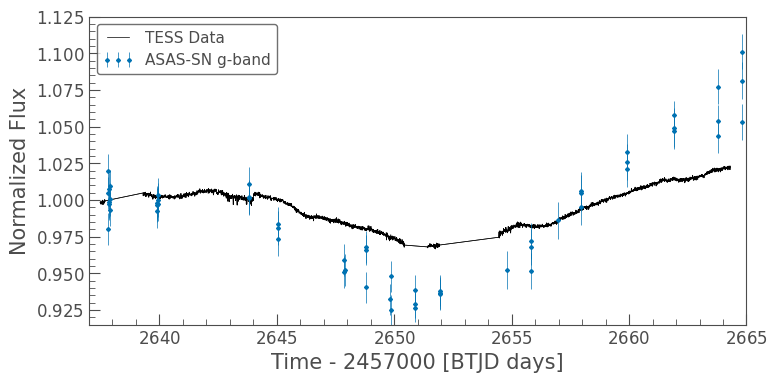

In [22]:
with plt.style.context(MPLSTYLE):  
    fig, ax = plt.subplots()
    lc.plot(ax=ax,normalize=True)
    plt.plot(lc.time.value,lc.flux.value/np.nanmedian(lc.flux.value),color='k',label='TESS Data')
    plt.errorbar(asas.HJD-2457000,asas.flux/np.median(asas.flux),yerr=asas.flux_err/np.median(asas.flux),
                fmt='D',label='ASAS-SN g-band')
    ax.set_ylim(0.915,1.125)
    ax.set_xlim(2637,2665)
    ax.legend(loc=2)

The ASAS-SN observations appear to have an over-all similar long-timescale behavior (given the caveats above) over the course of the sector, so we can have some confidence that these trends are from our source target itself. 

**Any further calibration to this lightcurve that we do will be model dependent.**  This is because the standard way to reduce the TESS data involves trying to flatten its systematics out as much as possible; so to preserve this longer timescale information we will have to model it such that when it gets removed as part of our de-trending process, we can subsequently add it back in in our final products. 

Lets see what the variability timescales that we can detect with these observations are.  To do this, we can use the lightkurve [to_periodogram()](https://docs.lightkurve.org/reference/api/lightkurve.LightCurve.to_periodogram.html#) function to get a Lomb Scargle periodogram of the power spectra of these observations.  

/opt/conda/envs/tess/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


<Axes: xlabel='Frequency [$\\mathrm{\\frac{1}{d}}$]', ylabel='Power [$\\mathrm{\\frac{e^{-}}{s}}$]'>

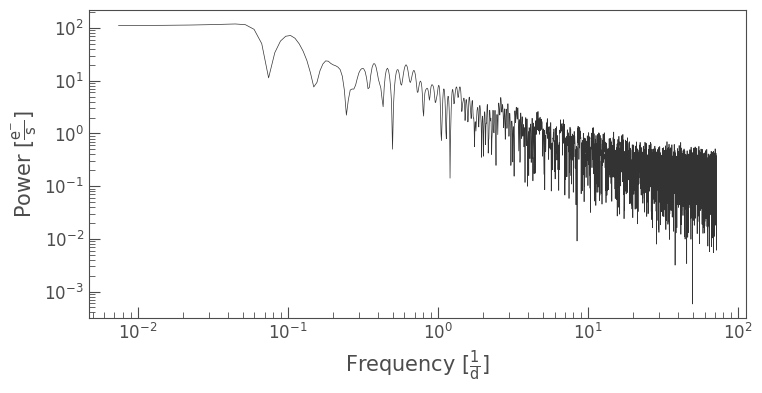

In [23]:
pd=lc.to_periodogram(method='lombscargle')
pd.plot(scale='log')

This is a little noisy, we can also bin the power spectrum to see if we can make any peaks stand out:

<Axes: xlabel='Frequency [$\\mathrm{\\frac{1}{d}}$]', ylabel='Power [$\\mathrm{\\frac{e^{-}}{s}}$]'>

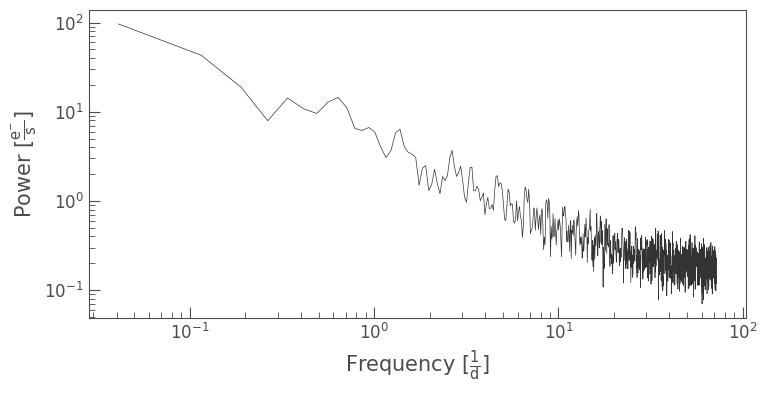

In [24]:
pdb=pd.bin(binsize=10)
pdb.plot(scale='log')

# Finally, Lets save our lightcurve and tpf files for later use
Lightkurve has a built-in save functionality which will allow you to write both lightcurve objects and target pixel file objects to fits files for later use

In [19]:
lc.to_fits(path='workshop_material/NGC4151_lc_bkgsub.fits',overwrite=True)
tpf.to_fits('workshop_material/NGC4151_tpf_bkgsub.fits',overwrite=True)

Value for TARGETID is None.


These can also be easily re-ingested by lightkurve using the read function:

In [20]:
lc=lk.read('workshop_material/NGC4151_lc_bkgsub.fits',quality_bitmask='none')
tpf=lk.read('workshop_material/NGC4151_tpf_bkgsub.fits',quality_bitmask='none')

We're also going to save our masks for use in our later notebook covering using a long-baseline model in the reduction.

In [21]:
#Save our target mask as a fits image
target_hdu=fits.PrimaryHDU(target_mask.astype(int))
target_hdu.writeto('workshop_material/target_mask.fits',overwrite=True)

In [22]:
#Save our bigger mask as a fits image
bigger_hdu=fits.PrimaryHDU(bigger_mask.astype(int))
bigger_hdu.writeto('workshop_material/bigger_mask.fits',overwrite=True)